# Monthly Accuracy Assessment of Water Observations from Space (WOfS) Product in Africa

## Description
Now that we have run WOfS classification for each AEZs in Africa, its time to conduct seasonal accuracy assessment for each AEZ in Africa which is already compiled and stored in the following folder:`02_Validation_results/WOfS_Assessment/Point_Based/ValidPoints_Per_AEZ`.

Accuracy assessment for WOfS product in Africa includes generating a confusion error matrix for a WOFL binary classification.
The inputs for the estimating the accuracy of WOfS derived product are a binary classification WOFL layer showing water/non-water and a shapefile containing validation points collected by [Collect Earth Online](https://collect.earth/) tool. Validation points are the ground truth or actual data while the extracted value for each location from WOFL is the predicted value. 

This notebook will explain how you can perform seasonal accuracy assessment for WOfS starting with `Western` AEZ using collected ground truth dataset. It will output a confusion error matrix containing overall, producer's and user's accuracy, along with the F1 score for each class.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import os
import rasterio
import xarray
import glob
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import matplotlib.pyplot as plt
import scipy, scipy.ndimage
import warnings
warnings.filterwarnings("ignore") #this will suppress the warnings for multiple UTM zones in your AOI 

from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import plot_confusion_matrix, f1_score  
from deafrica_tools.plotting import map_shapefile,display_map, rgb
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.datahandling import wofs_fuser, mostcommon_crs,load_ard,deepcopy
from deafrica_tools.dask import create_local_dask_cluster

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


### Analysis Parameters 

- CEO : groundtruth points containing valid points in each AEZ containing WOfS assigned classes, WOfS clear observations and the labels identified by analyst in each calendar month 
- input_data : dataframe for further analysis and accuracy assessment 

### Load the Dataset

Validation points that are valid for each AEZ  

## Wet/dry season

In [2]:
accuracies = {}
months = np.arange(1,13)
def wetdry_accuracy(aez_name, wet_range=None, dry_range=None):
    #CEO = f'../02_Validation_results/WOfS_Assessment/Point_Based/ValidPoints_Per_AEZ/ValidationPoints_{aez_name}.csv'
    CEO = f'../02_Validation_results/WOfS_Assessment/wofs_ls/{aez_name}_wofs_ls_validation_points.csv'
    input_data = pd.read_csv(CEO,delimiter=",")
    input_data=input_data.drop(['Unnamed: 0'], axis=1)
    working_wet = {}
    working_dry = {}
    
    for i in wet_range:
        is_month = input_data["MONTH"]==i
        monthly = input_data[is_month]
        if len(monthly)>=7:
            confusion_matrix = pd.crosstab(monthly['ACTUAL'],monthly['PREDICTION'],
                                           rownames=['ACTUAL'],colnames=['PREDICTION'],margins=True)
            confusion_matrix["Producer's"] = [confusion_matrix.loc[0][0] / confusion_matrix.loc[0]['All'] * 100, 
                                              confusion_matrix.loc[1][1] / confusion_matrix.loc[1]['All'] *100, np.nan]
            users_accuracy = pd.Series([confusion_matrix[0][0] / confusion_matrix[0]['All'] * 100,
                                        confusion_matrix[1][1] / confusion_matrix[1]['All'] * 100]).rename("User's")
            confusion_matrix = confusion_matrix.append(users_accuracy)
            confusion_matrix.loc["User's", "Producer's"] = (confusion_matrix[0][0] + confusion_matrix[1][1]) / confusion_matrix['All']['All'] * 100
            input_data['PREDICTION'] = input_data['PREDICTION'] .astype(str).astype(int)
            fscore = pd.Series([(2*(confusion_matrix.loc["User's"][0]*confusion_matrix.loc[0]["Producer's"]) / (confusion_matrix.loc["User's"][0] + confusion_matrix.loc[0]["Producer's"])) / 100,
                           f1_score(input_data['ACTUAL'],input_data['PREDICTION'])]).rename("F-score")
            confusion_matrix = confusion_matrix.append(fscore)
            confusion_matrix = confusion_matrix.round(decimals=2)
            confusion_matrix = confusion_matrix.rename(columns={'0':'NoWater','1':'Water', 0:'NoWater',1:'Water','All':'Total'},
                                                       index={'0':'NoWater','1':'Water',0:'NoWater',1:'Water','All':'Total'})
            working_wet[i]=confusion_matrix
        else:
            #pass
            confusion_matrix = pd.crosstab(monthly['ACTUAL'],monthly['PREDICTION'],
                                           rownames=['ACTUAL'],colnames=['PREDICTION'],margins=True)
            confusion_matrix["Producer's"] = [np.nan, np.nan]
            users_accuracy = pd.Series([np.nan,
                                        np.nan]).rename("User's")
            confusion_matrix = confusion_matrix.append(users_accuracy)
            confusion_matrix.loc["User's", "Producer's"] = np.nan
            input_data['PREDICTION'] = input_data['PREDICTION'] .astype(str).astype(int)
            fscore = pd.Series([np.nan,np.nan]).rename("F-score")
            confusion_matrix = confusion_matrix.append(fscore)
            confusion_matrix = confusion_matrix.round(decimals=2)
            confusion_matrix = confusion_matrix.rename(columns={'0':'NoWater','1':'Water', 0:'NoWater',1:'Water','All':'Total'},
                                                       index={'0':'NoWater','1':'Water',0:'NoWater',1:'Water','All':'Total'})
            working_wet[i]=confusion_matrix
            
    for i in dry_range:
        is_month = input_data["MONTH"]==i
        monthly = input_data[is_month]
        if len(monthly)>=7:
            confusion_matrix = pd.crosstab(monthly['ACTUAL'],monthly['PREDICTION'],
                                           rownames=['ACTUAL'],colnames=['PREDICTION'],margins=True)
            confusion_matrix["Producer's"] = [confusion_matrix.loc[0][0] / confusion_matrix.loc[0]['All'] * 100, 
                                              confusion_matrix.loc[1][1] / confusion_matrix.loc[1]['All'] *100, np.nan]
            users_accuracy = pd.Series([confusion_matrix[0][0] / confusion_matrix[0]['All'] * 100,
                                        confusion_matrix[1][1] / confusion_matrix[1]['All'] * 100]).rename("User's")
            confusion_matrix = confusion_matrix.append(users_accuracy)
            confusion_matrix.loc["User's", "Producer's"] = (confusion_matrix[0][0] + confusion_matrix[1][1]) / confusion_matrix['All']['All'] * 100
            input_data['PREDICTION'] = input_data['PREDICTION'] .astype(str).astype(int)
            fscore = pd.Series([(2*(confusion_matrix.loc["User's"][0]*confusion_matrix.loc[0]["Producer's"]) / (confusion_matrix.loc["User's"][0] + confusion_matrix.loc[0]["Producer's"])) / 100,
                           f1_score(input_data['ACTUAL'],input_data['PREDICTION'])]).rename("F-score")
            confusion_matrix = confusion_matrix.append(fscore)
            confusion_matrix = confusion_matrix.round(decimals=2)
            confusion_matrix = confusion_matrix.rename(columns={'0':'NoWater','1':'Water', 0:'NoWater',1:'Water','All':'Total'},
                                                       index={'0':'NoWater','1':'Water',0:'NoWater',1:'Water','All':'Total'})
            working_dry[i]=confusion_matrix
        else:
            #pass
            confusion_matrix = pd.crosstab(monthly['ACTUAL'],monthly['PREDICTION'],
                                           rownames=['ACTUAL'],colnames=['PREDICTION'],margins=True)
            confusion_matrix["Producer's"] = [np.nan, np.nan]
            users_accuracy = pd.Series([np.nan,
                                        np.nan]).rename("User's")
            confusion_matrix = confusion_matrix.append(users_accuracy)
            confusion_matrix.loc["User's", "Producer's"] = np.nan
            input_data['PREDICTION'] = input_data['PREDICTION'] .astype(str).astype(int)
            fscore = pd.Series([np.nan,np.nan]).rename("F-score")
            confusion_matrix = confusion_matrix.append(fscore)
            confusion_matrix = confusion_matrix.round(decimals=2)
            confusion_matrix = confusion_matrix.rename(columns={'0':'NoWater','1':'Water', 0:'NoWater',1:'Water','All':'Total'},
                                                       index={'0':'NoWater','1':'Water',0:'NoWater',1:'Water','All':'Total'})
            working_dry[i]=confusion_matrix
    producer_wet = [] 
    user_wet = []
    overall_wet = []
    producer_dry = [] 
    user_dry = []
    overall_dry = []
    for i in wet_range: 
        is_month = input_data["MONTH"]==i
        monthly = input_data[is_month]
        producer_wet.append(working_wet[i]["Producer's"][1])
        user_wet.append(working_wet[i]["Water"][3])
        overall_wet.append(working_wet[i]["Producer's"][3])
    for i in dry_range: 
        is_month = input_data["MONTH"]==i
        monthly = input_data[is_month]
        producer_dry.append(working_dry[i]["Producer's"][1])
        user_dry.append(working_dry[i]["Water"][3])
        overall_dry.append(working_dry[i]["Producer's"][3])
    accuracies[aez_name]={"Wet":{"Producer":producer_wet, 
                          "User":user_wet, 
                          "Overall":overall_wet},
                          "Dry":{"Producer":producer_dry, 
                          "User":user_dry, 
                          "Overall":overall_dry}}   

In [3]:
wetdry_accuracy('Central', wet_range=[10], dry_range=[6])
wetdry_accuracy('Eastern', wet_range=[4], dry_range=[10])
wetdry_accuracy('Western', wet_range=[6], dry_range=[12])
wetdry_accuracy('Northern', wet_range=[12], dry_range=[7])
wetdry_accuracy('Southern', wet_range=[1], dry_range=[7])
wetdry_accuracy('Sahel', wet_range=[8], dry_range=[2])
wetdry_accuracy('Indian_ocean', wet_range=[2], dry_range=[8])

In [4]:
accuracies

{'Central': {'Wet': {'Producer': [72.88], 'User': [93.48], 'Overall': [74.67]},
  'Dry': {'Producer': [86.54], 'User': [98.54], 'Overall': [86.39]}},
 'Eastern': {'Wet': {'Producer': [80.39], 'User': [91.11], 'Overall': [83.33]},
  'Dry': {'Producer': [83.98], 'User': [95.6], 'Overall': [86.36]}},
 'Western': {'Wet': {'Producer': [58.97], 'User': [100.0], 'Overall': [64.44]},
  'Dry': {'Producer': [85.35], 'User': [98.26], 'Overall': [85.96]}},
 'Northern': {'Wet': {'Producer': [84.38],
   'User': [91.53],
   'Overall': [84.21]},
  'Dry': {'Producer': [68.52], 'User': [90.24], 'Overall': [76.4]}},
 'Southern': {'Wet': {'Producer': [73.12],
   'User': [97.14],
   'Overall': [82.69]},
  'Dry': {'Producer': [77.71], 'User': [96.06], 'Overall': [82.06]}},
 'Sahel': {'Wet': {'Producer': [79.17], 'User': [65.52], 'Overall': [77.27]},
  'Dry': {'Producer': [96.15], 'User': [86.21], 'Overall': [87.18]}},
 'Indian_ocean': {'Wet': {'Producer': [80.23],
   'User': [97.87],
   'Overall': [80.73]},

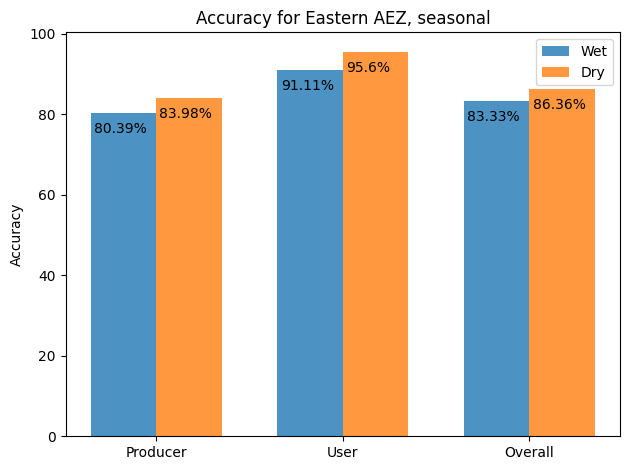

In [5]:
# from: https://pythonspot.com/matplotlib-bar-chart/
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 3
east_vals_wet = np.asarray(list(accuracies["Eastern"]["Wet"].values())).flatten()
east_vals_dry = np.asarray(list(accuracies["Eastern"]["Dry"].values())).flatten()
west_vals_wet = np.asarray(list(accuracies["Western"]["Wet"].values())).flatten()
west_vals_dry = np.asarray(list(accuracies["Western"]["Dry"].values())).flatten()
north_vals_wet = np.asarray(list(accuracies["Northern"]["Wet"].values())).flatten()
north_vals_dry = np.asarray(list(accuracies["Northern"]["Dry"].values())).flatten()
south_vals_wet = np.asarray(list(accuracies["Southern"]["Wet"].values())).flatten()
south_vals_dry = np.asarray(list(accuracies["Southern"]["Dry"].values())).flatten()
cent_vals_wet = np.asarray(list(accuracies["Central"]["Wet"].values())).flatten()
cent_vals_dry = np.asarray(list(accuracies["Central"]["Dry"].values())).flatten()
sahel_vals_wet = np.asarray(list(accuracies["Sahel"]["Wet"].values())).flatten()
sahel_vals_dry = np.asarray(list(accuracies["Sahel"]["Dry"].values())).flatten()
io_vals_wet = np.asarray(list(accuracies["Indian_ocean"]["Wet"].values())).flatten()
io_vals_dry = np.asarray(list(accuracies["Indian_ocean"]["Dry"].values())).flatten()

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

wet = plt.bar(index, east_vals_wet, bar_width,
alpha=opacity,
label='Wet')

dry = plt.bar(index + bar_width, east_vals_dry, bar_width,
alpha=opacity,
label='Dry')

plt.xlabel('')
plt.ylabel('Accuracy')
plt.title('Accuracy for Eastern AEZ, seasonal')
plt.xticks(index + 0.5*bar_width, (accuracies["Western"]["Wet"].keys()))
plt.text(-0.45*bar_width, east_vals_wet[0]-5, str(east_vals_wet[0])+'%')
plt.text(0.55*bar_width, east_vals_dry[0]-5, str(east_vals_dry[0])+'%')
plt.text(1-0.45*bar_width, east_vals_wet[1]-5, str(east_vals_wet[1])+'%')
plt.text(1+0.55*bar_width, east_vals_dry[1]-5, str(east_vals_dry[1])+'%')
plt.text(2-0.45*bar_width, east_vals_wet[2]-5, str(east_vals_wet[2])+'%')
plt.text(2+0.55*bar_width, east_vals_dry[2]-5, str(east_vals_dry[2])+'%')


plt.legend()

plt.tight_layout()
plt.show()
fig.savefig("Eastern_one_time_season_acc.png", bbox_inches='tight')